In [1]:
import sys
import numpy as np
import copy
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import csv
from sklearn.cluster import KMeans

# BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

BIRCH è un algoritmo progettato per il clustering incrementale di grandi dataset, con attributi di tipo metrico.<br>
La sua efficienza si basa su una struttura dati chiamata **CF Tree** (Clustering Feature Tree), 
che rappresenta i cluster in modo compatto e gerarchico.

Il CF Tree una la struttura ad albero bilanciato. È utilizzata da BIRCH per mantenere un "riassunto" dei cluster in memoria invece che tutti i datapoints.

**La struttura ad albero e la sua costruzione sono il cuore dell'algoritmo**.

### Clustering Features
Ogni nodo dell'albero contiene una lista di **Clustering Feature (CF)**, ovvero strutture compatte che riassumono un sottoinsieme di punti del dataset.

Un Clustering Feature è definita come una tripla:
- **N**: numero di punti
- **LS (Linear Sum)**: somma dei vettori dei punti, $\vec{LS} = \sum_{i=1}^{N} \vec{x}_i$

- **SS (Square Sum)**: somma dei quadrati dei vettori dei punti, $\text{SS} = \sum_{i=1}^{N} \|\vec{x}_i\|^2$

Queste quantità permettono di calcolare centroide, raggio e diametro di ogni cluster. Infatti:

- Il **centroide** del cluster è $\vec{C} = \frac{1}{N} \sum_{i=1}^{N} \vec{x}_i = \frac{\vec{LS}}{N}$

- Il **raggio**, che rappresenta la misura della dispersione dei punti rispetto al centroide, è $R = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( \vec{x}_i - \vec{C} \right)^2 }  = \sqrt{ \frac{SS}{N} - \left( \frac{\vec{LS}}{N} \right)^2 }$

- Il **diametro**, che rappresenta la distanza massima media tra i punti del cluster, è $D = \sqrt{\frac{1}{N(N - 1)} \sum_{i=1}^{N} \sum_{j = 1}^{N} \left( \vec{x_i} - \vec{x_j} \right)^2} = \sqrt{\frac{2N \cdot SS - 2  \|\vec{LS}\|^2}{N(N-1)}}$

Grazie a questa rappresentazione, si può pensare a un cluster come a un insieme di punti, ma memorizzato solo tramite il vettore CF come "riassunto". <br> Inoltre è efficiente perchè permette l'aggiornamento veloce al merge di due cluster: basta sommare i due CF corrispondenti grazie al *teorema di addittività*:

Assumiamo che $\text{CF}_1 = (N_1, \vec{LS}_1, SS_1)$
e $\text{CF}_2 = (N_2, \vec{LS}_2, SS_2)$ siano i vettori CF di due cluster disgiunti.<br>
Allora, il vettore CF del cluster formato unendo i due cluster disgiunti è: $\text{CF}_1 + \text{CF}_2 = \left( N_1 + N_2, \vec{LS}_1 + \vec{LS}_2, SS_1 + SS_2 \right)$.

Il Clustering Feature non è solo efficiente perché memorizza molto meno rispetto a tutti i punti dati del cluster, ma è anche accurato perché è sufficiente per calcolare tutte le misure necessarie per prendere decisioni di clustering in BIRCH.


In [2]:
class ClusteringFeature:
    def __init__(self, data_dimensionality):
        self.N = 0
        self.LS = np.zeros(data_dimensionality)
        self.SS = 0

    def add_point(self, x):
        self.N += 1
        self.LS += np.array(x)
        self.SS += np.dot(x, x)
        return self

    def merge(self, other: 'ClusteringFeature'):
        self.N += other.N
        self.LS += other.LS
        self.SS += other.SS
        return self

    def centroid(self):
        if self.N == 0:
            return np.zeros_like(self.LS)
        return self.LS / self.N

    def radius(self):
        centroid = self.centroid()
        variance = (self.SS / self.N) - np.dot(centroid, centroid)
        # Evita numeri negativi
        variance = max(variance, 0)
        return float(np.sqrt(variance))

    def diameter(self):
        if self.N <= 1:
            return 0.0
        numerator = 2 * self.N * np.sum(self.SS) - 2 * np.dot(self.LS, self.LS)
        denominator = self.N * (self.N - 1)
        diameter_sq = numerator / denominator
        return np.sqrt(diameter_sq)

    def dist(self, other: 'ClusteringFeature') -> float:
        # Distanza euclidea tra i centroidi di due ClusteringFeature
        return float(np.linalg.norm(self.centroid() - other.centroid()))

    def __repr__(self):
        return f"ClusteringFeature(N={self.N}, LS={self.LS}, SS={self.SS:.4f})"

    def __copy__(self):
        copied = ClusteringFeature(np.size(self.LS, 0))
        copied.merge(self)
        return copied

    def __eq__(self, value: object) -> bool:
        if value is not None and isinstance(value, ClusteringFeature):
            return self.N == value.N and all(self.LS == value.LS) and self.SS == value.SS
        return False

    def __sizeof__(self) -> int:
        to_return = 0
        for element in (self.N, self.LS, self.SS):
            to_return += sys.getsizeof(element)
        return to_return

### CF Tree

Un albero CF è un albero bilanciato in altezza con due parametri: 
- **branching factor B** 
- **threshold T**.<br>

Ogni nodo dell'albero contiene una lista di CF (al massimo B) e, ogni CF contiene il puntatore al suo (unico) nodo padre ed al suo (unico) nodo figlio.

Quindi B è il numero massimo di figli per nodo interno, i.e. il numero massimo di CF che possono essere memorizzati in un nodo.

T è il raggio massimo di un cluster, o fattore di assorbimento, determina la distanza massima consentita tra un punto dati e il centroide di un cluster affinché quel punto venga incluso nel cluster.<br>
Aiuta a controllare la compattezza dei cluster.

#### Algoritmo di inserimento di un datapoint
1. Ricerca della foglia appropriata per l'inserimento di `Ent`.
	- Si parte dalla radice dell’albero.
	- Ad ogni livello si cerca il CF del nodo padre più vicino ad `Ent` e ci si sposta nel nodo figlio corrispondente. Per il concetto di "vicinanza" uso la distanza euclidea tra il centroide del CF ed `Ent`.
	- Si continua a discendere l’albero seguendo un path di CF fino a raggiungere un nodo foglia.
2. Individuazione del CF più vicino nella foglia
	- All'interno del nodo foglia trovato, si calcola la distanza tra `Ent` ed ogni CF presente nella foglia.
	- Si seleziona il CF più vicino come candidato per assorbire `Ent`.
3. Tentativo di inserimento di `Ent` nella foglia
	- Se il CF selezionato può assorbire `Ent` senza che il raggio (o diametro) superi la soglia `T`:
		* `Ent` viene aggiunto al CF, aggiornandone i parametri `(N, LS, SS)`.
	- Se il CF non può assorbire `Ent`, si valuta la capacità della foglia:
		* Se la foglia ha spazio (cioè il numero di CF è < `B`):
			* Si crea un nuovo CF per `Ent` e lo si aggiunge alla foglia.
		* Se la foglia è piena:
			* `Ent` viene inserito temporaneamente come nuovo CF nella foglia.
			* La foglia viene splittata:
				- Si individuano i due CF più distanti tra quelli nella foglia: saranno i semi di due nuovi nodi foglia.
				- Gli altri CF vengono assegnati al seme più vicino.
				- La foglia diventa un nodo interno con due nuovi figli.
				- Se il padre ha spazio, si aggiorna la sua lista di CF.
				- Se il padre non ha spazio, si ripete lo split ricorsivamente verso l’alto.
				- Se la root viene splittata, l’albero cresce in altezza (viene creata una nuova root).
4. Aggiornamento del path
	- Dopo l'inserimento, si aggiornano i CF lungo il cammino dalla foglia alla radice, per riflettere l’aggiunta del nuovo punto (si aggiornano i CF aggregati nei nodi interni).
5. Refinement per ottimizzare la struttura (Merging Refinement)
	- Se un nodo padre ha figli appena splittati ed ha ancora spazio disponibile:
		- Si esegue uno scan dei CF presenti nel nodo.
		- Si cercano i due CF più vicini (non entrambi quelli dello split precedente).
		- Si valuta la possibilità di fondere i due CF:
		- Si uniscono le loro child list sotto uno dei due CF.
		- L’altro CF viene rimosso dal nodo padre, liberando spazio.
		- Se il nuovo CF risultante ha troppe child list (supera `B`):
			- Si esegue un nuovo split locale per bilanciare la distribuzione.

##### Osservazioni
Un datapoint viene inserito sempre e solo in uno nodo foglia, non in nodi interni.<br>
Il datapoint è rappresentabile come un CF.<br>
Questo algoritmo va eseguito per tutti i punti da inserire.

In [ ]:
class CFTree:
    def __init__(self, data_dimensionality, branching_factor, threshold, is_leaf: bool, parent=None):
        self.branching_factor = branching_factor
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.data_dimensionality = data_dimensionality
        self.parent = parent
        self.CF_list: list[ClusteringFeature] = []
        # Lista dei figli (solo se non è foglia)
        self.children_list: list['CFTree'] = []

    def insert_CF(self, cf: ClusteringFeature, outlier=False) -> bool:
        # Se nodo leaf
        if self.is_leaf:
            # Se non ci sono ancora CF nel nodo leaf
            if not self.CF_list:
                self.CF_list.append(cf)
                return True

            # Provo a vedere se il più vicino e quello in input sono < T
            # 'closest_cf' è un CF, il più vicino al CF passato in input
            closest = self.find_closest_CF(cf)
            closest_cf = self.CF_list[closest]
            temp_cf = copy.copy(closest_cf)
            temp_cf.merge(cf)

            if temp_cf.radius() < self.threshold:
                # Se si, we are good to go, aggiungo e basta
                closest_cf.merge(cf)
                return True
            elif not outlier:
                # Altrimenti aggiungo il CF al nodo
                self.CF_list.append(cf)
                return True
        # Se il nodo non è foglia
        else:
            closest = self.find_closest_CF(cf)
            # Attraverso l'indice trovo il nodo figlio
            child = self.children_list[closest]

            # Inserisco il CF nel figlio, aka chiamo ricorsivamente questo metodo
            to_return = child.insert_CF(cf)

            if len(child.CF_list) > self.branching_factor:
                seed1, seed2 = self.split_child(closest)
                if len(self.children_list) <= self.branching_factor:
                    # Merging refinement
                    self.merge_refinement(seed1, seed2)
            else:
                # Aggiorna il CF cumulativo del figlio
                self.CF_list[closest] = self.children_list[closest].compute_cumulative_CF(
                )
            return to_return
        return False

    def _find_index(self, mode="furthest"):
        # Trova l'indice della coppia di CF più lontani o più vicini
        op = 1.0 if mode == "furthest" else -1.0
        seed1 = 0
        seed2 = 0
        max_dist = -float("inf")
        for i in range(len(self.CF_list)-1):
            for j in range(i + 1, len(self.CF_list)):
                dist = op * self.CF_list[i].dist(self.CF_list[j])
                if dist > max_dist:
                    max_dist = dist
                    seed1 = i
                    seed2 = j
        return seed1, seed2

    def split_child(self, idx: int) -> tuple[int, int]:
        # Esegue lo split del figlio all’indice `idx` nel nodo corrente
        child = self.children_list[idx]
        # Find i nodi più lontani
        seed1, seed2 = child._find_index(mode="furthest")

        # Crea due nuovi nodi
        params_dict = {"data_dimensionality": self.data_dimensionality,
                       "branching_factor": self.branching_factor,
                       "threshold": self.threshold,
                       "is_leaf": child.is_leaf,
                       "parent": self
                       }
        new_node1 = CFTree(**params_dict)
        new_node2 = CFTree(**params_dict)
        # Inserisce i due semi nei nuovi nodi
        new_node1.CF_list.append(child.CF_list[seed1])
        new_node2.CF_list.append(child.CF_list[seed2])
        if not child.is_leaf:
            # >> hanno figli
            new_node1.children_list.append(child.children_list[seed1])
            new_node2.children_list.append(child.children_list[seed2])

        # Inserisco i restanti CF
        for node_idx, cf in enumerate(child.CF_list):
            if node_idx not in (seed2, seed1):
                dist1 = cf.dist(new_node1.CF_list[0])
                dist2 = cf.dist(new_node2.CF_list[0])
                if dist1 < dist2:
                    # Inserisco nel nuovo tree
                    new_node1.CF_list.append(cf)
                    if not child.is_leaf:
                        # >> ha figli e li inserisco
                        new_node1.children_list.append(
                            child.children_list[node_idx])
                else:
                    new_node2.CF_list.append(cf)
                    if not child.is_leaf:
                        new_node2.children_list.append(
                            child.children_list[node_idx])
        # Aggiunge i due nuovi nodi come figli del nodo corrente
        self.children_list.append(new_node1)
        self.CF_list.append(new_node1.compute_cumulative_CF())
        self.children_list.append(new_node2)
        self.CF_list.append(new_node2.compute_cumulative_CF())
        # Rimuove il nodo figlio originale
        self.CF_list.pop(idx)
        self.children_list.pop(idx)
        return len(self.children_list) - 2, len(self.children_list) - 1

    def find_closest_CF(self, cf: ClusteringFeature) -> int:
        # Trova l'indice del CF più vicino in base al centroide
        min_dist = float('inf')
        closest = 0
        for idx, node in enumerate(self.CF_list):
            dist = np.linalg.norm(node.centroid() - cf.centroid())
            if dist < min_dist:
                min_dist = dist
                closest = idx
        return closest

    def compute_cumulative_CF(self):
        # Calcola il ClusteringFeature aggregato del nodo
        cf = ClusteringFeature(self.data_dimensionality)
        for entry in self.CF_list:
            cf.merge(entry)
        return cf

    def _find_smallest_increase(self) -> float:
        # Calcola la distanza minima tra coppie per stimare densità
        if self.is_leaf:
            # Trova i più vicini
            seed1, seed2 = self._find_index("smallest")
            dist = self.CF_list[seed1].dist(self.CF_list[seed2])
            # Ritorna la loro distanza
            return dist
        # Else trova il figlio più denso
        idx_max = np.argmax(list(map(lambda x: x.N, self.CF_list)))
        return self.children_list[idx_max]._find_smallest_increase()

    def merge_refinement(self, split1, split2):
        # Step 1: trova i due CF più vicini
        seed1, seed2 = self._find_index("closest")
        # Se non sono sia split1 che split2
        if split1 != seed1 or split2 != seed2:
            temp_cf = copy.copy(self.CF_list[seed1])
            temp_cf.merge(self.CF_list[seed2])
            # Se posso unirli
            if temp_cf.radius() < self.threshold:
                # Se si possono unire, trasferisce tutte le foglie del secondo nel primo
                for leaf in self.children_list[seed2].leaves():
                    self.children_list[seed1].insert_CF(leaf)
                # Svuota spazio
                self.children_list.pop(seed2)
                self.CF_list.pop(seed2)
                # Se troppo grandi splitta
                if len(self.children_list[seed1].children_list) > self.branching_factor:
                    self.split_child(seed1)
        return self

    def paths(self, path: list[int] = []):
        # Genera tutte le possibili path fino alle foglie
        if self.is_leaf:
            yield path
        else:
            for idx, node in enumerate(self.children_list):
                copied = path + [idx]
                yield from node.paths(copied)

    def _avg_nodes_in_leaves(self) -> int:
        # Restituisce il numero medio di punti per foglia
        total_nodes = self.compute_cumulative_CF().N
        leaves_number = 0
        for leaf in self.leaves():
            leaves_number += 1
        return total_nodes // leaves_number

    def leaves(self):
        # Ritorna tutti i CF delle foglie
        if self.is_leaf:
            for cf in self.CF_list:
                yield cf
        else:
            for child in self.children_list:
                yield from child.leaves()

    def __getitem__(self, path):
        current_node = self
        for node in path:
            current_node = current_node.children_list[node]
        return current_node

    def __repr__(self, level=0) -> str:
        to_return = ""
        indent = "-- " * level
        for idx, node in enumerate(self.CF_list):
            to_return += f"{indent}- {node}\n"
            if self.children_list:
                child = self.children_list[idx]
                to_return += child.__repr__(level + 1)
        return to_return

    def __sizeof__(self) -> int:
        size = object.__sizeof__(self)
        size += sum(sys.getsizeof(cf) for cf in self.CF_list)
        size += sum(child.__sizeof__() for child in self.children_list or [])
        return size

### Esempio di costruzione del CF Tree su un dataset piccolo.
Costruisce un albero bilanciato, dove ogni nodo contiene al massimo `B=2` Clustering Features (in base alla soglia di raggio `T=1.5`). 

In [4]:
tree = CFTree(2, 2, 1.5, True)
data = [[3, 4], [2, 6], [4, 5], [4, 7], [3, 8],
        [6, 2], [7, 2], [7, 4], [8, 4], [7, 9]]
for point in data:
    tree.insert_CF(ClusteringFeature(2).add_point(np.array(point)))
    if len(tree.CF_list) > tree.branching_factor:
        new_root = CFTree(tree.data_dimensionality,
                          tree.branching_factor, tree.threshold, False)
        tree.parent = new_root
        new_root.CF_list.append(tree.compute_cumulative_CF())
        new_root.children_list.append(tree)
        new_root.split_child(0)
        tree = new_root
print(tree)

- ClusteringFeature(N=4, LS=[28. 12.], SS=238.0000)
-- - ClusteringFeature(N=4, LS=[28. 12.], SS=238.0000)
-- -- - ClusteringFeature(N=4, LS=[28. 12.], SS=238.0000)
- ClusteringFeature(N=6, LS=[23. 39.], SS=374.0000)
-- - ClusteringFeature(N=1, LS=[7. 9.], SS=130.0000)
-- -- - ClusteringFeature(N=1, LS=[7. 9.], SS=130.0000)
-- - ClusteringFeature(N=5, LS=[16. 30.], SS=244.0000)
-- -- - ClusteringFeature(N=4, LS=[13. 22.], SS=171.0000)
-- -- - ClusteringFeature(N=1, LS=[3. 8.], SS=73.0000)



### Algoritmo di BIRCH
1. **Costruzione del CF Tree**: i dati vengono inseriti uno a uno nell’albero.
2. *(Opzionale)* **Condensazione del CF Tree**: ha lo scopo di estrarre informazioni utili dai dati compressi nel CF Tree da usare come base per il prossimo punto dell'algoritmo.
3. **Clustering globale**: si applica un algoritmo classico (es. KMeans) ai micro-cluster.

4. *(Opzionale e off-line)* **Cluster Refining**: si rifinisce la soluzione ovvero assegna i dati originali al cluster del centroide più vicino.

In [5]:
class BIRCH:
    def __init__(self, data_dim=2, page_size=4096, threshold=0.0, max_size=100_000, estimated_data_size=105_000) -> None:
        self.max_size = max_size
        self.data_dim = data_dim
        self.branching_factor = page_size // sys.getsizeof(
            ClusteringFeature(data_dim))
        self.threshold = threshold
        self.max_size = max_size
        self.tree = CFTree(
            self.data_dim, self.branching_factor, self.threshold, True)
        self.old_thresholds: list[list[float]] = [[threshold]]
        self.N_added_list: list[list[int]] = []
        self.radii: list[list[float]] = []
        self.N = estimated_data_size
        self.outlier_threshold = 0
        self.outliers: list[ClusteringFeature] = []
        self.outlier_mem_size = 20 * max_size // 100

    def addall(self, nodefile):
        with open(nodefile, "rt") as f:
            reader = csv.reader(f)
            for row, text in enumerate(reader):
                # Controllo che l'albero non sia troppo grande
                if sys.getsizeof(self.tree) > self.max_size:
                    # Ricalcola threshold
                    self.recompute_threshold(row)
                # Comprimi l'albero in uno più piccolo usando la nuova soglia
                    self.compress()
                # Aggiungo un nodo
                coordinates = np.array(text, dtype=float)
                cf = ClusteringFeature(self.data_dim).add_point(coordinates)
                self.tree.insert_CF(cf)
                # Controlla che la root non sia troppo grande
                if len(self.tree.CF_list) > self.branching_factor:
                    # Crea una nuova
                    new_root = CFTree(
                        self.data_dim, self.branching_factor, self.threshold, False)
                    self.tree.parent = new_root
                    new_root.CF_list.append(self.tree.compute_cumulative_CF())
                    new_root.children_list.append(self.tree)
                    # Dividi quella vecchia
                    new_root.split_child(0)
                    self.tree = new_root
            # Check se gli outliers possono essere assorbiti back nell'albero, altrimenti vengono sartati
            to_remove = [self.tree.insert_CF(
                outlier, outlier=True) for outlier in self.outliers]
            self.outliers = [outlier for idx, outlier in enumerate(
                self.outliers) if not to_remove[idx]]
            return self

    def recompute_threshold(self, row: int):
        # Stima quanti dati vogliamo aggiungere alla prossima iterazione
        N_next = min(self.N, 2 * row)
        # Calcola il raggio della root
        root = self.tree.compute_cumulative_CF()
        radius = root.radius()
        self.radii.append([radius])
        self.N_added_list.append([row])

        model = LinearRegression()
        # Packed volume V_p = T^d, aumenta linearmente con con la threshold
        N_power = [[number[0] ** (1/self.data_dim)]
                   for number in self.N_added_list]
        # Stima la prossima threshold
        model.fit(N_power, self.old_thresholds)
        next_threshold = model.predict(np.array(N_next).reshape(-1, 1))[0][0]
        # Stima il prossimo raggio
        model.fit(self.N_added_list, self.radii)
        radius = model.predict(np.array(N_next).reshape(-1, 1))[0][0]

        expansion_factor = max(1.0, float(radius / self.radii[-1][0]))
        # Trova nel cluster con più nodi le foglie più vicine
        d_min = self.tree._find_smallest_increase()

        next_threshold = min(d_min, float(expansion_factor * next_threshold))
        # Se non è abbastanza grande incrementala
        if next_threshold <= self.old_thresholds[-1][0]:
            next_threshold = next_threshold*(N_next/row)**(1/self.data_dim)
        # Evita 0.0 come nuova threshold
        if next_threshold == 0.0:
            next_threshold = 0.0001
        self.old_thresholds.append([next_threshold])
        self.threshold = next_threshold
        return None

    def compress(self):
        # Soglia per decidere se un leaf CF è un outlier
        # Calcola il numero medio di nodi nelle foglie
        self.outlier_threshold = max(
            self.outlier_threshold, self.tree._avg_nodes_in_leaves() // 4)
        compressed = CFTree(
            self.data_dim, self.branching_factor, self.threshold, True)

        for leaf in self.tree.leaves():
            if leaf.N > self.outlier_threshold:
                compressed.insert_CF(leaf)
            # Se questo nodo ha meno di 20% di punti della media
            else:
                self.manage_outliers(compressed, leaf)
        self.tree = compressed
        return self

    def manage_outliers(self, compressed: CFTree, leaf: ClusteringFeature):
        # Aggiungi alla lista dioutliers
        self.outliers.append(leaf)
        # Se gli outlier sono troppi
        if sys.getsizeof(self.outliers) > self.outlier_mem_size:
            # Reinserisci outlier e guarda quali sono stati reinseriti
            to_remove = [compressed.insert_CF(
                outlier, outlier=True) for outlier in self.outliers]
            # Tieni quelli che non sono stati reinseriti
            self.outliers = [outlier for idx, outlier in enumerate(
                self.outliers) if not to_remove[idx]]

### Esempio su un dataset sintetico di 100K punti

In [ ]:
# Generiamo dataset
X, y = make_blobs(n_samples=100000, centers=10, random_state=42)
# Aggiungiamo un po' di noise
noise = np.random.uniform(low=-20, high=20, size=(5000, 2))
X = np.vstack([X, noise])
np.random.shuffle(X)
with open("data.csv", "tw") as f:
    writer = csv.writer(f)
    writer.writerows(X)

In [ ]:
birch = BIRCH()
birch.addall("data.csv")
print(birch.tree)

- ClusteringFeature(N=105074, LS=[-1367326.02869864 -1401392.86682057], SS=36928884.0700)
-- - ClusteringFeature(N=28603, LS=[-408565.70686122 -408904.34510332], SS=11720556.8602)
-- - ClusteringFeature(N=16802, LS=[-234172.78809933 -201939.36452065], SS=5708497.9888)
-- - ClusteringFeature(N=14618, LS=[-171825.62316504 -175472.42828111], SS=4149721.9508)
-- - ClusteringFeature(N=41442, LS=[-524238.92314126 -556930.82730342], SS=14180147.4082)
-- - ClusteringFeature(N=1763, LS=[-13786.4841812  -26875.42073365], SS=519676.7328)
-- - ClusteringFeature(N=1846, LS=[-14736.50325059 -31270.48087841], SS=650283.1292)
- ClusteringFeature(N=50079, LS=[-137147.16685257 -418518.8646231 ], SS=3980470.6792)
-- - ClusteringFeature(N=3, LS=[  8.85891705 -13.30434764], SS=90.1189)
-- - ClusteringFeature(N=7, LS=[-28.87462473 -15.89918438], SS=166.7771)
-- - ClusteringFeature(N=28085, LS=[ -93787.73854873 -237333.97735072], SS=2360639.2021)
-- - ClusteringFeature(N=19513, LS=[ -35697.71494809 -164037.2

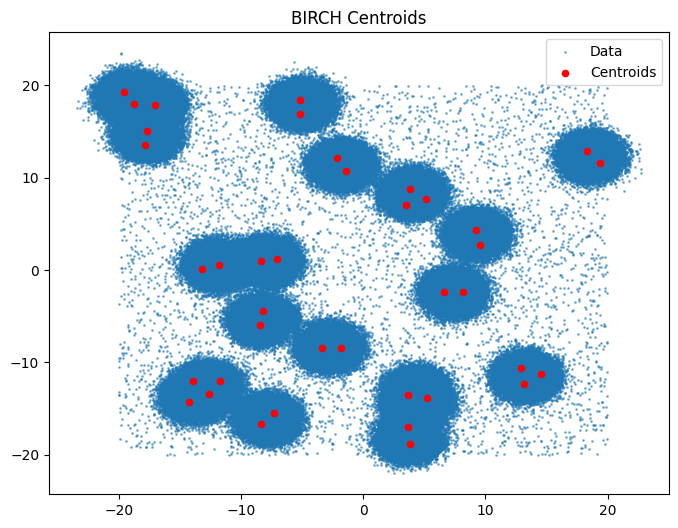

In [21]:
centroids = [leaf.centroid() for leaf in birch.tree.leaves()]
centroids = np.array(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.5, label="Data")
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, label="Centroids")
plt.legend()
plt.title("BIRCH Centroids")
plt.show()

#### Gestione degli Outlier in BIRCH

BIRCH può gestire opzionalmente gli outlier durante la costruzione del CF Tree. In particolare, quando si ricostruisce l’albero (ad esempio per limiti di memoria), alcuni micro-cluster (foglie) con **densità molto bassa** possono essere **considerati outlier potenziali**.

Questi outlier vengono:
- **Esclusi** dal nuovo albero CF e **scritti** in una struttura temporanea.
- In un secondo momento, **riesaminati** per vedere se possono essere **riassorbiti** con un nuovo threshold o una nuova distribuzione.

Un micro-cluster viene considerato outlier se contiene **molti meno punti della media** delle foglie. Alla fine del processo, i micro-cluster che **non possono essere riassorbiti** vengono considerati **veri outlier** e possono essere scartati.

In [9]:
print(birch.compress(birch.threshold).tree)

- ClusteringFeature(N=3699, LS=[-33789.28253554  37023.89427776], SS=682698.9730)
- ClusteringFeature(N=3519, LS=[-37121.52993122  33717.81504158], SS=717926.9317)
- ClusteringFeature(N=4145, LS=[-39431.35400584  33783.88080557], SS=653699.4672)
- ClusteringFeature(N=1607, LS=[-12877.83653981  14409.50750999], SS=233351.7207)
- ClusteringFeature(N=3321, LS=[-26141.95590808  24033.28185068], SS=382629.9515)
- ClusteringFeature(N=3836, LS=[-35668.7278937   25317.07482569], SS=502486.6967)
- ClusteringFeature(N=969, LS=[ 751.29524992 4344.3765251 ], SS=21003.6617)
- ClusteringFeature(N=2963, LS=[-4583.4604366  28250.95808824], SS=279169.8087)
- ClusteringFeature(N=2154, LS=[-7059.38271967 21533.28554726], SS=240028.6868)
- ClusteringFeature(N=4368, LS=[-12824.60458706  36873.6561317 ], SS=352974.3270)
- ClusteringFeature(N=572, LS=[-1064.23090791  4166.57146768], SS=32833.9412)
- ClusteringFeature(N=6176, LS=[-44515.27598892 -36511.95240591], SS=542529.9558)
- ClusteringFeature(N=1714, LS

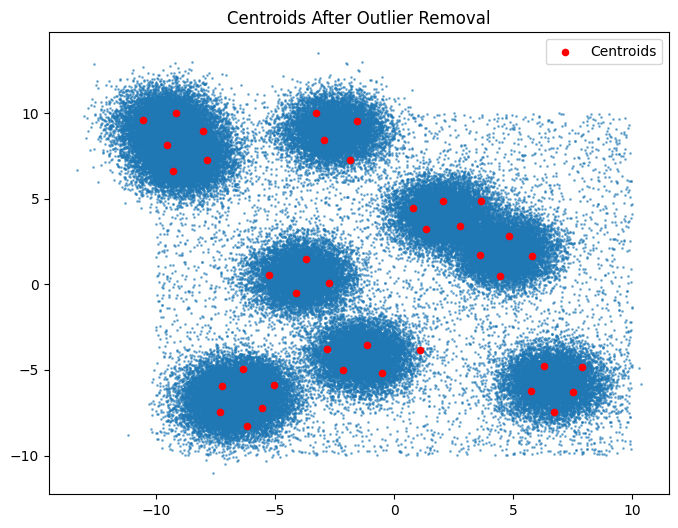

In [ ]:
centroids = [leaf.centroid() for leaf in birch.tree.leaves()]
centroids = np.array(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, label="Centroids")
plt.legend()
plt.title("Centroids After Outlier Removal")
plt.show()

#### Clustering globale
I cluster finali vengono creati applicando una seconda fase di tecniche di clustering (io ho utilizzato **K-Means**) ai cluster già formati nell'albero CF.
Questo passaggio finale migliora l’accuratezza complessiva e garantisce che i cluster risultanti siano ben separati e rappresentativi.

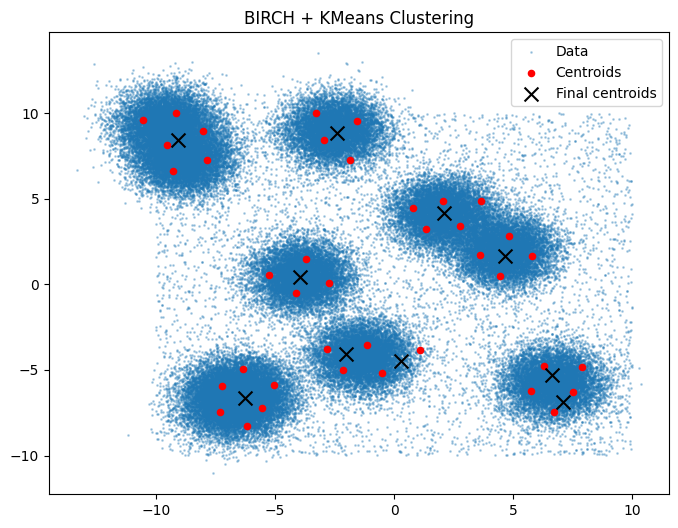

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(centroids)
final_centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.3, label="Data")
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, label="Centroids")
plt.scatter(final_centroids[:, 0], final_centroids[:, 1],
            c='black', s=100, marker='x', label="Final centroids")
plt.legend()
plt.title("BIRCH + KMeans Clustering")
plt.show()

### Parametri

##### `page_size`
Ovvero la dimensione di una pagina di memoria. Questa dovrebbe contenere un nodo dell'albero interamente.

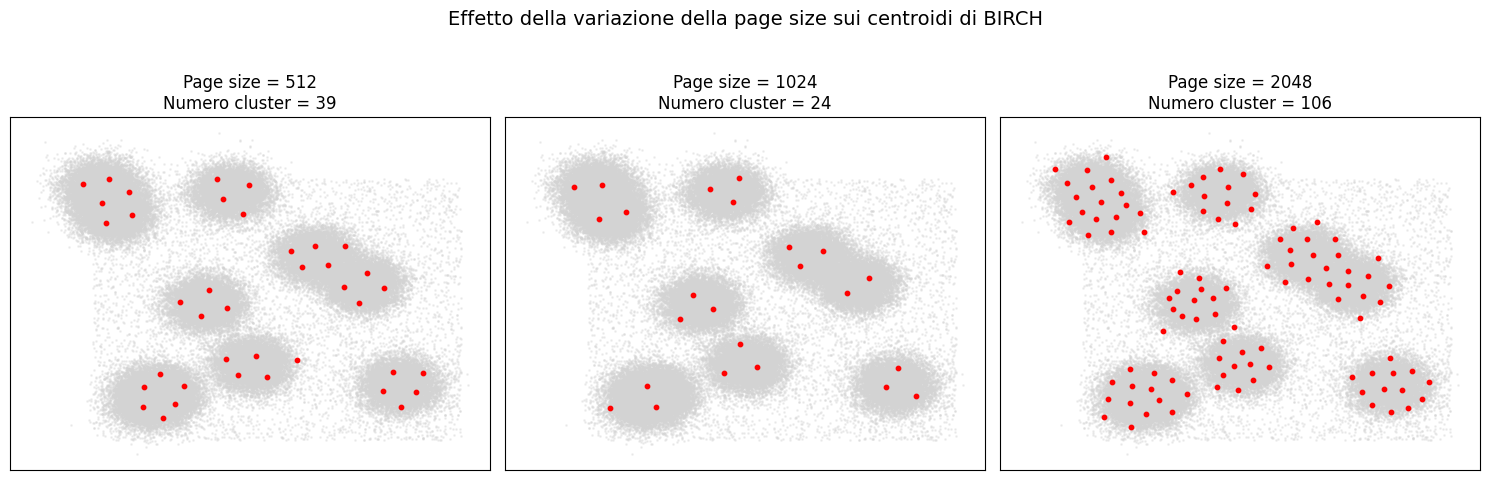

In [ ]:
page_sizes = [512, 1024, 2048]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, p in enumerate(page_sizes):
    birch_compare = BIRCH(page_size=p)
    birch_compare.addall("data.csv")
    birch_compare.compress(birch_compare.threshold)

    centroids_compare = [leaf.centroid()
                         for leaf in birch_compare.tree.leaves()]
    centroids_compare = np.array(centroids_compare)

    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], color="lightgray", s=1, alpha=0.3)
    ax.scatter(centroids_compare[:, 0],
               centroids_compare[:, 1], color="red", s=10)
    ax.set_title(f"Page size = {p}\n"
                 f"Numero cluster = {len(birch_compare.tree.CF_list)}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(
    "Effetto della variazione della page size sui centroidi di BIRCH", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### `max_size`
Ovvero il numero di dati massimo da processare prima di fare il re-build dell'albero.

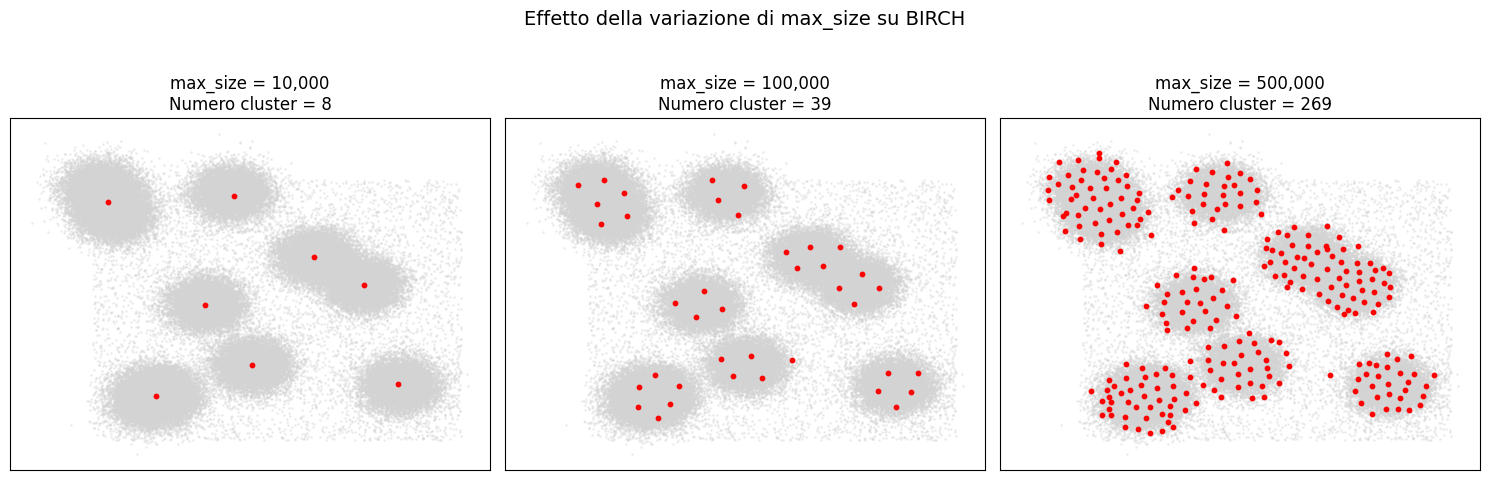

In [ ]:
max_sizes = [10_000, 100_000, 500_000]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, max_size in enumerate(max_sizes):
    birch_compare = BIRCH(max_size=max_size)
    birch_compare.addall("data.csv")
    birch_compare.compress(birch_compare.threshold)

    centroids_compare = [leaf.centroid()
                         for leaf in birch_compare.tree.leaves()]
    centroids_compare = np.array(centroids_compare)

    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], color="lightgray", s=1, alpha=0.3)
    ax.scatter(centroids_compare[:, 0],
               centroids_compare[:, 1], color="red", s=10)
    ax.set_title(f"max_size = {max_size:,}\n"
                 f"Numero cluster = {len(birch_compare.tree.CF_list)}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Effetto della variazione di max_size su BIRCH", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Limitazioni
BIRCH è un algoritmo estremamente efficiente e scalabile per grandi dataset, ma presenta alcuni limiti:

- Sensibile all’ordine dei dati: l’albero CF viene costruito in modo incrementale, quindi l’ordine con cui i dati vengono letti può influenzare la struttura dei micro-cluster.
- Fa difficoltà con cluster non convessi.
- Fa difficoltà con dati ad alta dimensionalità

### Confornto con altre tecniche 

In generale BIRCH non richiede la memorizzazione dei datapoints in memoria, come succede invece per altre tecniche di clustering. Infatti fa un uso efficiente della struttura ad albero per processare grandi dataset.

La sua astuzia sta nel memorizzare e aggiornare ad ogni inserimento un "riassunto" dei datapoints.

* DBSCAN: non è sensibile all'ordine con cui vengono processati i dati, gestisce bene gli outliers.
* Agglomerative Clustering: fa difficoltà con gli outliers (dipende dalla metrica scelta), ha complessità computazionale alta, ma può gestire anche forme complesse della distribuzione del dataset.